In [3]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

df = pd.read_csv("../data/combined_essays.csv")
from src.preprocess import clean_text
df["text_pp"] = df["text"].apply(clean_text)

texts = df["text_pp"].tolist()
y      = df["generated"].values

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_minilm = model.encode(texts, batch_size=128, show_progress_bar=True)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_minilm, y, test_size=0.20, random_state=42, stratify=y
)

svm = LinearSVC(class_weight="balanced")
svm.fit(X_tr, y_tr)
y_pred = svm.predict(X_val)


/Users/williamleroy/PycharmProjects/PythonProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/williamleroy/PycharmProjects/PythonProject/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


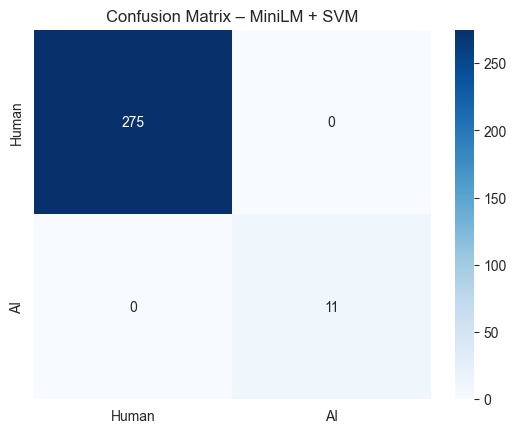

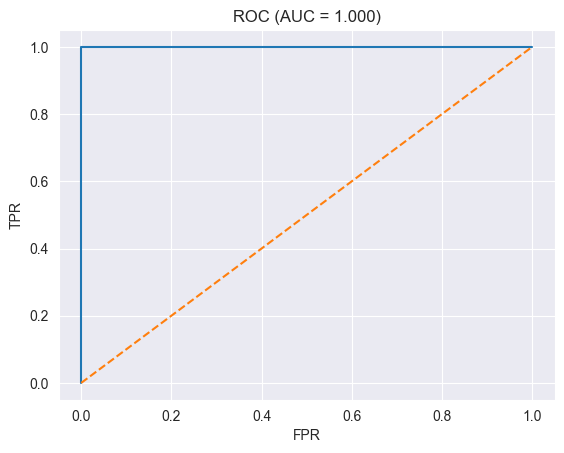

<Figure size 640x480 with 0 Axes>

In [6]:
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human","AI"], yticklabels=["Human","AI"])
plt.title("Confusion Matrix – MiniLM + SVM");
plt.show()
#plt.savefig("../reports/figures/confusion_minilm_svm.png", dpi=300)

scores = svm.decision_function(X_val)
fpr, tpr, _ = roc_curve(y_val, scores)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (AUC = {auc(fpr,tpr):.3f})");
plt.show()
#plt.savefig("../reports/figures/roc_minilm_svm.png", dpi=300)


/Users/williamleroy/PycharmProjects/PythonProject/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/williamleroy/PycharmProjects/PythonProject/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


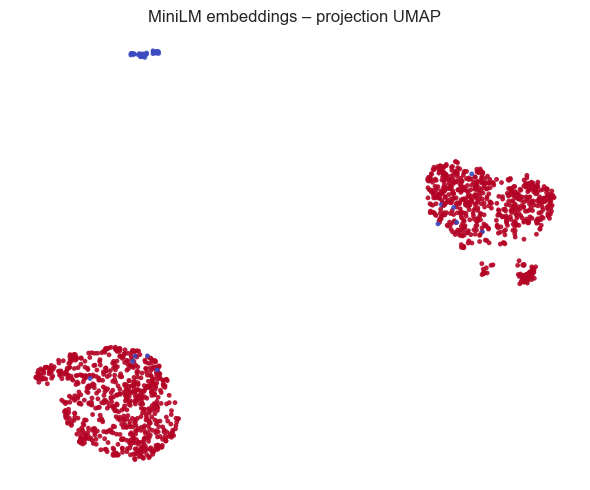

In [7]:
import umap, matplotlib.pyplot as plt
import numpy as np

reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
emb2d = reducer.fit_transform(X_minilm)

plt.figure(figsize=(6, 5))
plt.scatter(
    emb2d[:, 0], emb2d[:, 1],
    c=y, cmap="coolwarm_r", s=12, alpha=0.9, edgecolors="none"
)
plt.title("MiniLM embeddings – projection UMAP")
plt.axis("off")
plt.tight_layout()

# plt.savefig("../reports/figures/umap_minilm.png", dpi=300)

plt.show()
